In [1]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import random
from collections import defaultdict
import copy
import ast
import csv
import numpy as np

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [2]:
gat_explanations = {}
gcn_explanations = {}
tagcn_explanations = {}

with open("explanations_gat.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:  # Check if row is not empty
            index = row[0]
            tensor_str = row[1]
            tensor_list = ast.literal_eval(tensor_str)
            gat_explanations[index] = tensor_list

with open("explanations_gcn.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:  # Check if row is not empty
            index = row[0]
            tensor_str = row[1]
            tensor_list = ast.literal_eval(tensor_str)
            gcn_explanations[index] = tensor_list

with open("explanations_tagcn.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:  # Check if row is not empty
            index = row[0]
            tensor_str = row[1]
            tensor_list = ast.literal_eval(tensor_str)
            tagcn_explanations[index] = tensor_list

In [28]:
def get_edge_frequencies(data, explanations):
    edge_frequencies_big = defaultdict(int)
    edge_frequencies_small = defaultdict(int)

    for i, edge_weight in explanations.items():
        edge_weight = torch.tensor(edge_weight)
        edge_index = data.edge_index

        significant_edge_mask_big = edge_weight > 0.3
        significant_edge_mask_small = edge_weight > 0.1
        significant_edge_index_big = edge_index[:, significant_edge_mask_big]
        significant_edge_index_small = edge_index[:, significant_edge_mask_small]

        for j in range(significant_edge_index_big.shape[1]):
            edge = tuple(sorted((significant_edge_index_big[0, j].item(), significant_edge_index_big[1, j].item())))
            edge_frequencies_big[edge] += 1

        for j in range(significant_edge_index_small.shape[1]):
            edge = tuple(sorted((significant_edge_index_small[0, j].item(), significant_edge_index_small[1, j].item())))
            edge_frequencies_small[edge] += 1

    return edge_frequencies_big, edge_frequencies_small


gat_edge_freq_big, gat_edge_freq_small = get_edge_frequencies(data, gat_explanations)
gcn_edge_freq_big, gcn_edge_freq_small = get_edge_frequencies(data, gcn_explanations)
tagcn_edge_freq_big, tagcn_edge_freq_small = get_edge_frequencies(data, tagcn_explanations)

# print(sorted(edge_freq_big.items(), key=lambda x: x[1], reverse=True))

In [29]:
def divide_into_chunks(freq, n):
    lst = sorted(freq.items(), key=lambda x: x[1])
    """Divide the list lst into n equally-sized chunks."""
    k, m = divmod(len(lst), n)
    return [lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]


num_bins = 10
gat_bins_big = divide_into_chunks(gat_edge_freq_big, num_bins)
gat_bins_small = divide_into_chunks(gat_edge_freq_small, num_bins)
gcn_bins_big = divide_into_chunks(gcn_edge_freq_big, num_bins)
gcn_bins_small = divide_into_chunks(gcn_edge_freq_small, num_bins)
tagcn_bins_big = divide_into_chunks(tagcn_edge_freq_big, num_bins)
tagcn_bins_small = divide_into_chunks(tagcn_edge_freq_small, num_bins)

## Make sure that the architecture, hyperparams, random seeds and training setup of the model are all identical to the model for which the explanations were generated

In [30]:
from torch_geometric.nn import GATConv, GCNConv, TAGConv
import torch.nn.functional as F


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

gat_model = GAT(hidden_channels=8, heads=8)
print(gat_model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [31]:
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def gat_train():
    gat_model.train()
    optimizer.zero_grad()
    out = gat_model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def gat_test(mask):
    gat_model.eval()
    out = gat_model(data.x, data.edge_index)
    out = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

In [32]:
for epoch in range(1, 101):
    loss = gat_train()
    val_acc = gat_test(data.val_mask)
    test_acc = gat_test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9438, Val: 0.3780, Test: 0.4090
Epoch: 002, Loss: 1.9364, Val: 0.5680, Test: 0.5890
Epoch: 003, Loss: 1.9266, Val: 0.6180, Test: 0.6180
Epoch: 004, Loss: 1.9165, Val: 0.6200, Test: 0.6210
Epoch: 005, Loss: 1.9050, Val: 0.6620, Test: 0.6550
Epoch: 006, Loss: 1.8944, Val: 0.7160, Test: 0.7260
Epoch: 007, Loss: 1.8821, Val: 0.7680, Test: 0.7490
Epoch: 008, Loss: 1.8728, Val: 0.7700, Test: 0.7710
Epoch: 009, Loss: 1.8592, Val: 0.7940, Test: 0.7860
Epoch: 010, Loss: 1.8463, Val: 0.7960, Test: 0.7880
Epoch: 011, Loss: 1.8381, Val: 0.7980, Test: 0.7830
Epoch: 012, Loss: 1.8246, Val: 0.7960, Test: 0.7790
Epoch: 013, Loss: 1.8105, Val: 0.7960, Test: 0.7790
Epoch: 014, Loss: 1.7909, Val: 0.7920, Test: 0.7770
Epoch: 015, Loss: 1.7859, Val: 0.7880, Test: 0.7760
Epoch: 016, Loss: 1.7616, Val: 0.7860, Test: 0.7760
Epoch: 017, Loss: 1.7493, Val: 0.7880, Test: 0.7780
Epoch: 018, Loss: 1.7317, Val: 0.7900, Test: 0.7760
Epoch: 019, Loss: 1.7235, Val: 0.7900, Test: 0.7770
Epoch: 020, 

In [33]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
gcn_model = GCN(hidden_channels=16)

In [34]:
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def gcn_train():
    gcn_model.train()
    optimizer.zero_grad()
    out = gcn_model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def gcn_test(mask):
    gcn_model.eval()
    out = gcn_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[mask] == data.y[mask]
    test_acc = int(test_correct.sum()) / int(mask.sum())
    return test_acc

In [35]:
for epoch in range(1, 101):
    loss = gcn_train()
    val_acc = gcn_test(data.val_mask)
    test_acc = gcn_test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9465, Val: 0.1660, Test: 0.1630
Epoch: 002, Loss: 1.9419, Val: 0.3220, Test: 0.3800
Epoch: 003, Loss: 1.9363, Val: 0.1880, Test: 0.2200
Epoch: 004, Loss: 1.9290, Val: 0.1780, Test: 0.2060
Epoch: 005, Loss: 1.9199, Val: 0.2280, Test: 0.2680
Epoch: 006, Loss: 1.9140, Val: 0.2800, Test: 0.3250
Epoch: 007, Loss: 1.9079, Val: 0.3440, Test: 0.3740
Epoch: 008, Loss: 1.8992, Val: 0.3740, Test: 0.4030
Epoch: 009, Loss: 1.8876, Val: 0.4040, Test: 0.4380
Epoch: 010, Loss: 1.8764, Val: 0.4280, Test: 0.4760
Epoch: 011, Loss: 1.8656, Val: 0.4660, Test: 0.4950
Epoch: 012, Loss: 1.8626, Val: 0.4840, Test: 0.5200
Epoch: 013, Loss: 1.8460, Val: 0.5080, Test: 0.5280
Epoch: 014, Loss: 1.8329, Val: 0.5200, Test: 0.5320
Epoch: 015, Loss: 1.8225, Val: 0.5280, Test: 0.5380
Epoch: 016, Loss: 1.8167, Val: 0.5520, Test: 0.5730
Epoch: 017, Loss: 1.7995, Val: 0.5880, Test: 0.5930
Epoch: 018, Loss: 1.7878, Val: 0.6080, Test: 0.6250
Epoch: 019, Loss: 1.7716, Val: 0.6100, Test: 0.6350
Epoch: 020, 

In [36]:
class TAGCN(torch.nn.Module):
    def __init__(self, hidden_channels, K):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = TAGConv(dataset.num_node_features, hidden_channels, K=K)
        self.conv2 = TAGConv(hidden_channels, dataset.num_classes, K=K)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
tagcn_model = TAGCN(hidden_channels=16, K=2)

In [37]:
optimizer = torch.optim.Adam(tagcn_model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def tagcn_train():
    tagcn_model.train()
    optimizer.zero_grad()
    out = tagcn_model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def tagcn_test(mask):
    tagcn_model.eval()
    out = tagcn_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[mask] == data.y[mask]
    test_acc = int(test_correct.sum()) / int(mask.sum())
    return test_acc

In [38]:
for epoch in range(1, 101):
    loss = tagcn_train()
    val_acc = tagcn_test(data.val_mask)
    test_acc = tagcn_test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9458, Val: 0.1080, Test: 0.1080
Epoch: 002, Loss: 1.9320, Val: 0.1960, Test: 0.2060
Epoch: 003, Loss: 1.9111, Val: 0.5400, Test: 0.5590
Epoch: 004, Loss: 1.8849, Val: 0.5540, Test: 0.5620
Epoch: 005, Loss: 1.8600, Val: 0.5480, Test: 0.5530
Epoch: 006, Loss: 1.8233, Val: 0.5360, Test: 0.5530
Epoch: 007, Loss: 1.7856, Val: 0.5440, Test: 0.5410
Epoch: 008, Loss: 1.7387, Val: 0.5580, Test: 0.5620
Epoch: 009, Loss: 1.7056, Val: 0.5880, Test: 0.5940
Epoch: 010, Loss: 1.6381, Val: 0.6160, Test: 0.6170
Epoch: 011, Loss: 1.5996, Val: 0.6400, Test: 0.6390
Epoch: 012, Loss: 1.5365, Val: 0.6500, Test: 0.6660
Epoch: 013, Loss: 1.4879, Val: 0.6680, Test: 0.6760
Epoch: 014, Loss: 1.4238, Val: 0.6760, Test: 0.6840
Epoch: 015, Loss: 1.3630, Val: 0.7040, Test: 0.6940
Epoch: 016, Loss: 1.3014, Val: 0.7240, Test: 0.7150
Epoch: 017, Loss: 1.2341, Val: 0.7360, Test: 0.7320
Epoch: 018, Loss: 1.1653, Val: 0.7440, Test: 0.7450
Epoch: 019, Loss: 1.0852, Val: 0.7500, Test: 0.7560
Epoch: 020, 

In [39]:
def generate_perturbations(data, edges_to_remove):
    data = copy.deepcopy(data)
    edges = data.edge_index.t()
    
    edges_set = set(map(tuple, edges.numpy()))
    remove_set = set(map(tuple, edges_to_remove.numpy()))

    keep_edges = edges_set - remove_set
    keep_edges = torch.tensor(list(keep_edges)).t()
    data.edge_index = keep_edges
    
    return data


def make_undirected(lst):
    lst = torch.tensor(lst)
    flipped = lst.flip(dims=[1])
    combined = torch.cat((lst, flipped), dim=0)
    return combined


def get_logit_diff(model, perturbed_data):
    model.eval()
    with torch.no_grad():
        out_orig = model(data.x, data.edge_index)
        out_perturb = model(data.x, perturbed_data.edge_index)
        logit_diff = out_orig - out_perturb
        l2_norm = torch.norm(logit_diff, p=2) / torch.norm(data.x, p=2)
        return l2_norm

In [40]:
num_samples = 10

gat_results_small = torch.zeros(num_bins, num_samples)
gat_results_big = torch.zeros(num_bins, num_samples)
gcn_results_small = torch.zeros(num_bins, num_samples)
gcn_results_big = torch.zeros(num_bins, num_samples)
tagcn_results_small = torch.zeros(num_bins, num_samples)
tagcn_results_big = torch.zeros(num_bins, num_samples)

gat_avg_freq_small = []
gat_avg_freq_big = []
gcn_avg_freq_small = []
gcn_avg_freq_big = []
tagcn_avg_freq_small = []
tagcn_avg_freq_big = []


def populate_result_tensors(bins, model, avg_freq, res):
    for i, bin in enumerate(bins):
        avg_freq.append(np.mean([i[1] for i in bin]))
        for j in range(num_samples):
            half_size = len(bin) // 2
            edges = [i[0] for i in bin]
            sampled_edges = random.sample(edges, half_size)
            edges_to_remove = make_undirected(sampled_edges)
            perturbed_data = generate_perturbations(data, edges_to_remove)
            res[i, j] = get_logit_diff(model, perturbed_data)


populate_result_tensors(gat_bins_small, gat_model, gat_avg_freq_small, gat_results_small)
populate_result_tensors(gat_bins_big, gat_model, gat_avg_freq_big, gat_results_big)
populate_result_tensors(gcn_bins_small, gcn_model, gcn_avg_freq_small, gcn_results_small)
populate_result_tensors(gcn_bins_big, gcn_model, gcn_avg_freq_big, gcn_results_big)
populate_result_tensors(tagcn_bins_small, tagcn_model, tagcn_avg_freq_small, tagcn_results_small)
populate_result_tensors(tagcn_bins_big, tagcn_model, tagcn_avg_freq_big, tagcn_results_big)

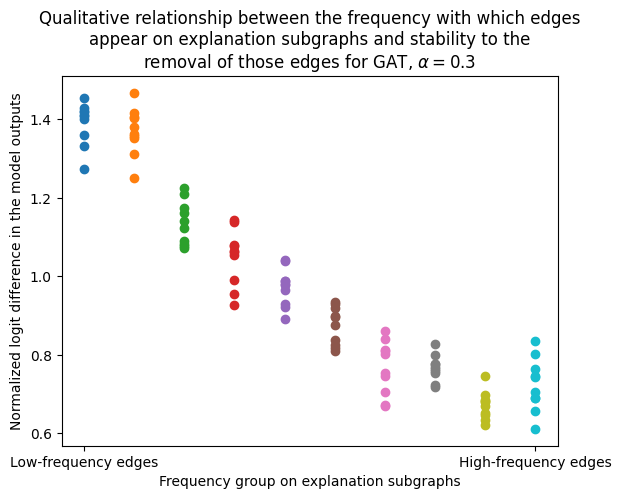

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(num_bins):
    x = [i] * num_samples
    y = gat_results_big[i].detach().numpy()
    ax.scatter(x, y, label=f'Bin {i+1}')

ax.set_xlabel('Frequency group on explanation subgraphs')
ax.set_ylabel('Normalized logit difference in the model outputs')
ax.set_xticks([0, num_bins-1])  # Set ticks only at the extremes
ax.set_xticklabels(['Low-frequency edges', 'High-frequency edges'])
ax.set_title('Qualitative relationship between the frequency with which edges\nappear on explanation subgraphs and stability to the\nremoval of those edges for GAT, $\\alpha=0.3$')
plt.show()

In [57]:
def get_node_frequencies(data, explanations):
    node_frequencies_big = defaultdict(int)
    node_frequencies_small = defaultdict(int)

    for i, edge_weight in explanations.items():
        edge_weight = torch.tensor(edge_weight)
        edge_index = data.edge_index

        significant_edge_mask_big = edge_weight > 0.3
        significant_edge_mask_small = edge_weight > 0.1
        significant_edge_index_big = edge_index[:, significant_edge_mask_big]
        significant_edge_index_small = edge_index[:, significant_edge_mask_small]

        nodes_big = np.unique(significant_edge_index_big.numpy())
        nodes_small = np.unique(significant_edge_index_small.numpy())

        for node in nodes_big:
            node_frequencies_big[node] += 1

        for node in nodes_small:
            node_frequencies_small[node] += 1

    return node_frequencies_big, node_frequencies_small


gat_node_freq_big, gat_node_freq_small = get_node_frequencies(data, gat_explanations)
gcn_node_freq_big, gcn_node_freq_small = get_node_frequencies(data, gcn_explanations)
tagcn_node_freq_big, tagcn_node_freq_small = get_node_frequencies(data, tagcn_explanations)

In [58]:
gat_node_bins_big = divide_into_chunks(gat_node_freq_big, num_bins)
gat_node_bins_small = divide_into_chunks(gat_node_freq_small, num_bins)
gcn_node_bins_big = divide_into_chunks(gcn_node_freq_big, num_bins)
gcn_node_bins_small = divide_into_chunks(gcn_node_freq_small, num_bins)
tagcn_node_bins_big = divide_into_chunks(tagcn_node_freq_big, num_bins)
tagcn_node_bins_small = divide_into_chunks(tagcn_node_freq_small, num_bins)

In [68]:
import torch_geometric.utils as pyg_utils


def generate_perturbations_node(data, nodes_to_remove):
    data = copy.deepcopy(data)
    nodes_to_remove = set(nodes_to_remove)

    mask = torch.ones(data.x.size(0), dtype=torch.bool)
    mask[list(nodes_to_remove)] = False
    
    data.x = data.x[mask]

    all_nodes = set(range(2708))
    nodes_to_retain = all_nodes.difference(nodes_to_remove)
    data.edge_index = pyg_utils.subgraph(sorted(nodes_to_retain), data.edge_index, relabel_nodes=True)[0]

    return data, mask


def get_logit_diff_node(data, perturbed_data, model, mask):
    model.eval()
    with torch.no_grad():
        out_orig = model(data.x, data.edge_index)
        out_perturb = model(perturbed_data.x, perturbed_data.edge_index)
        logit_diff = out_orig[mask] - out_perturb
        l2_norm = torch.norm(logit_diff, p=2) / torch.norm(data.x, p=2)
        return l2_norm

In [69]:
num_samples = 10

gat_results_small_node = torch.zeros(num_bins, num_samples)
gat_results_big_node = torch.zeros(num_bins, num_samples)
gcn_results_small_node = torch.zeros(num_bins, num_samples)
gcn_results_big_node = torch.zeros(num_bins, num_samples)
tagcn_results_small_node = torch.zeros(num_bins, num_samples)
tagcn_results_big_node = torch.zeros(num_bins, num_samples)

gat_avg_freq_small_node = []
gat_avg_freq_big_node = []
gcn_avg_freq_small_node = []
gcn_avg_freq_big_node = []
tagcn_avg_freq_small_node = []
tagcn_avg_freq_big_node = []


def populate_result_tensors_node(bins, model, avg_freq, res):
    for i, bin in enumerate(bins):
        avg_freq.append(np.mean([i[1] for i in bin]))
        for j in range(num_samples):
            half_size = len(bin) // 2
            nodes = [i[0] for i in bin]
            sampled_nodes = random.sample(nodes, half_size)
            perturbed_data, mask = generate_perturbations_node(data, sampled_nodes)
            res[i, j] = get_logit_diff_node(data, perturbed_data, model, mask)


populate_result_tensors_node(gat_node_bins_small, gat_model, gat_avg_freq_small_node, gat_results_small_node)
populate_result_tensors_node(gat_node_bins_big, gat_model, gat_avg_freq_big_node, gat_results_big_node)
populate_result_tensors_node(gcn_node_bins_small, gcn_model, gcn_avg_freq_small_node, gcn_results_small_node)
populate_result_tensors_node(gcn_node_bins_big, gcn_model, gcn_avg_freq_big_node, gcn_results_big_node)
populate_result_tensors_node(tagcn_node_bins_small, tagcn_model, tagcn_avg_freq_small_node, tagcn_results_small_node)
populate_result_tensors_node(tagcn_node_bins_big, tagcn_model, tagcn_avg_freq_big_node, tagcn_results_big_node)

torch.Size([10, 10])


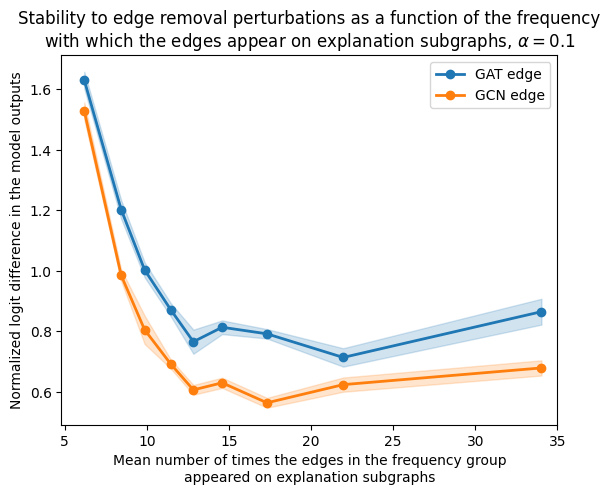

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def plot_with_confidence_intervals(avg_freq, results, label, color):
    # Calculate the mean and standard error of the mean (SEM)
    mean_values = np.mean(results, axis=1)
    sem_values = sem(results, axis=1)  # SEM is standard error of the mean

    # Calculate the confidence intervals (95% confidence level)
    ci_lower = mean_values - 1.96 * sem_values
    ci_upper = mean_values + 1.96 * sem_values

    # Plot the mean values with markers
    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2, marker='o')

    plt.xlim(right=35)

    # Plot the confidence intervals as shaded areas
    plt.fill_between(avg_freq, ci_lower, ci_upper, color=color, alpha=0.2)

# Plotting the results
plt.figure()

# Color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

print(gat_results_small.shape)
plot_with_confidence_intervals(gat_avg_freq_small[:-1], gat_results_small[:-1, :].numpy(), 'GAT edge', colors[0])
plot_with_confidence_intervals(gcn_avg_freq_small[:-1], gcn_results_small[:-1, :].numpy(), 'GCN edge', colors[1])
# plot_with_confidence_intervals(tagcn_avg_freq_small, tagcn_results_small.numpy(), 'TAGCN', colors[2])

plt.legend()
plt.xlabel('Mean number of times the edges in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('Normalized logit difference in the model outputs')
plt.title('Stability to edge removal perturbations as a function of the frequency\nwith which the edges appear on explanation subgraphs, $\\alpha=0.1$')
plt.show()

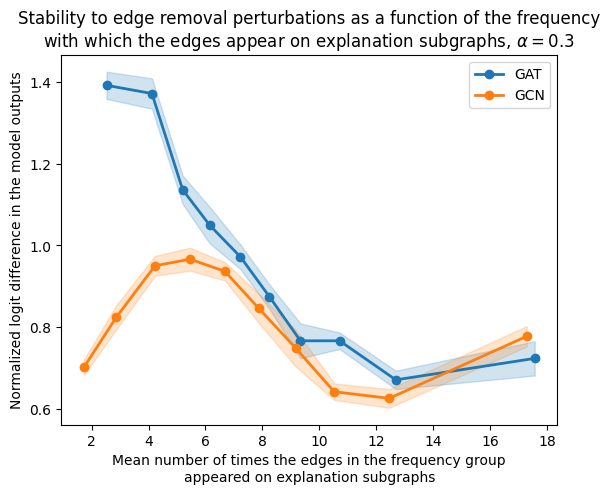

In [116]:
def plot_with_confidence_intervals(avg_freq, results, label, color):
    # Calculate the mean and standard error of the mean (SEM)
    mean_values = np.mean(results, axis=1)
    sem_values = sem(results, axis=1)  # SEM is standard error of the mean

    # Calculate the confidence intervals (95% confidence level)
    ci_lower = mean_values - 1.96 * sem_values
    ci_upper = mean_values + 1.96 * sem_values

    # Plot the mean values with markers
    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2, marker='o')

    # Plot the confidence intervals as shaded areas
    plt.fill_between(avg_freq, ci_lower, ci_upper, color=color, alpha=0.2)

# Plotting the results
plt.figure()

# Color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plot_with_confidence_intervals(gat_avg_freq_big, gat_results_big.numpy(), 'GAT', colors[0])
plot_with_confidence_intervals(gcn_avg_freq_big, gcn_results_big.numpy(), 'GCN', colors[1])
# plot_with_confidence_intervals(tagcn_avg_freq_big, tagcn_results_big.numpy(), 'TAGCN', colors[2])

plt.legend()
plt.xlabel('Mean number of times the edges in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('Normalized logit difference in the model outputs')
plt.title('Stability to edge removal perturbations as a function of the frequency\nwith which the edges appear on explanation subgraphs, $\\alpha=0.3$')
plt.show()

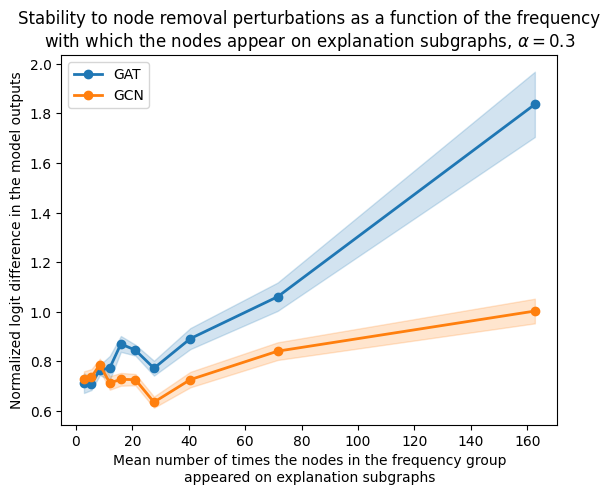

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def plot_with_confidence_intervals(avg_freq, results, label, color):
    # Calculate the mean and standard error of the mean (SEM)
    mean_values = np.mean(results, axis=1)
    sem_values = sem(results, axis=1)  # SEM is standard error of the mean

    # Calculate the confidence intervals (95% confidence level)
    ci_lower = mean_values - 1.96 * sem_values
    ci_upper = mean_values + 1.96 * sem_values

    # Plot the mean values with markers
    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2, marker='o')

    # Plot the confidence intervals as shaded areas
    plt.fill_between(avg_freq, ci_lower, ci_upper, color=color, alpha=0.2)

# Plotting the results
plt.figure()

# Color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plot_with_confidence_intervals(gat_avg_freq_small_node, gat_results_small_node.numpy(), 'GAT', colors[0])
plot_with_confidence_intervals(gcn_avg_freq_small_node, gcn_results_small_node.numpy(), 'GCN', colors[1])
# plot_with_confidence_intervals(tagcn_avg_freq_small_node, tagcn_results_small_node.numpy(), 'TAGCN', colors[2])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('Normalized logit difference in the model outputs')
plt.title('Stability to node removal perturbations as a function of the frequency\nwith which the nodes appear on explanation subgraphs, $\\alpha=0.3$')
plt.show()

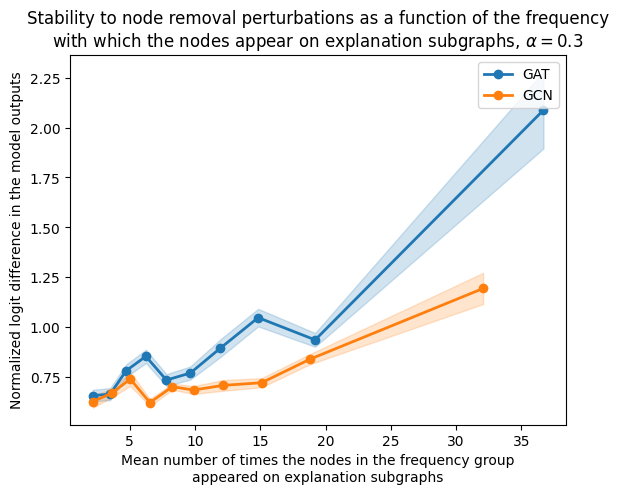

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def plot_with_confidence_intervals(avg_freq, results, label, color):
    # Calculate the mean and standard error of the mean (SEM)
    mean_values = np.mean(results, axis=1)
    sem_values = sem(results, axis=1)  # SEM is standard error of the mean

    # Calculate the confidence intervals (95% confidence level)
    ci_lower = mean_values - 1.96 * sem_values
    ci_upper = mean_values + 1.96 * sem_values

    # Plot the mean values with markers
    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2, marker='o')

    # Plot the confidence intervals as shaded areas
    plt.fill_between(avg_freq, ci_lower, ci_upper, color=color, alpha=0.2)

# Plotting the results
plt.figure()

# Color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plot_with_confidence_intervals(gat_avg_freq_big_node, gat_results_big_node.numpy(), 'GAT', colors[0])
plot_with_confidence_intervals(gcn_avg_freq_big_node, gcn_results_big_node.numpy(), 'GCN', colors[1])
# plot_with_confidence_intervals(tagcn_avg_freq_big_node, tagcn_results_big_node.numpy(), 'TAGCN', colors[2])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('Normalized logit difference in the model outputs')
plt.title('Stability to node removal perturbations as a function of the frequency\nwith which the nodes appear on explanation subgraphs, $\\alpha=0.3$')
plt.show()

In [111]:
from torch_geometric.utils import degree

node_degrees = degree(data.edge_index[0], num_nodes=data.num_nodes)
node_degrees_per_bin_gat = []
degree_one_nodes_per_bin_gat = []
degree_two_nodes_per_bin_gat = []
node_degrees_per_bin_gcn = []
degree_one_nodes_per_bin_gcn = []

for i, bin in enumerate(gat_bins_small):
    nodes_in_bin = np.unique([i[0] for i in bin])
    node_degrees_per_bin_gat.append(torch.mean(node_degrees[nodes_in_bin]).item())

for i, bin in enumerate(gcn_bins_small):
    nodes_in_bin = np.unique([i[0] for i in bin])
    node_degrees_per_bin_gcn.append(torch.mean(node_degrees[nodes_in_bin]).item())

In [112]:
for i, bin in enumerate(gat_bins_small):
    nodes_in_bin = np.unique([i[0] for i in bin])
    mask = (node_degrees[nodes_in_bin] == 1)
    mask_2 = (node_degrees[nodes_in_bin] == 2)
    degree_one_nodes_per_bin_gat.append(mask.sum().item())
    degree_two_nodes_per_bin_gat.append(mask_2.sum().item())

for i, bin in enumerate(gcn_bins_small):
    nodes_in_bin = np.unique([i[0] for i in bin])
    mask = (node_degrees[nodes_in_bin] == 1)
    degree_one_nodes_per_bin_gcn.append(mask.sum().item())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


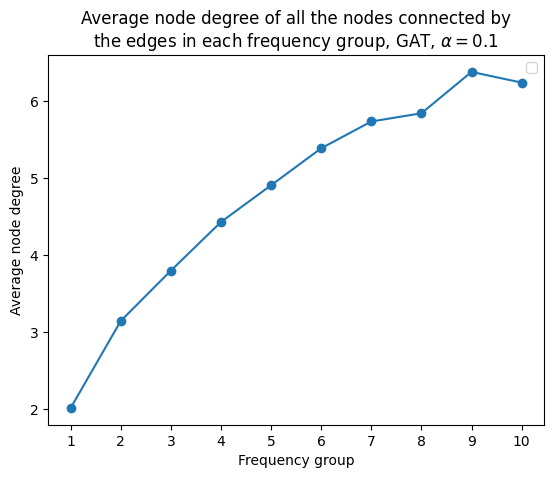

In [113]:
x = range(1, 11)

plt.figure()  # You can adjust the size of the figure
plt.plot(x, node_degrees_per_bin_gat, marker='o')  # Plot array1
# plt.plot(x, node_degrees_per_bin_gcn, label='GCN', marker='o')  # Plot array1

plt.title('Average node degree of all the nodes connected by\nthe edges in each frequency group, GAT, $\\alpha=0.1$')
plt.xticks(x)
plt.xlabel('Frequency group')
plt.ylabel('Average node degree')
plt.legend()

# Show the plot
plt.show()

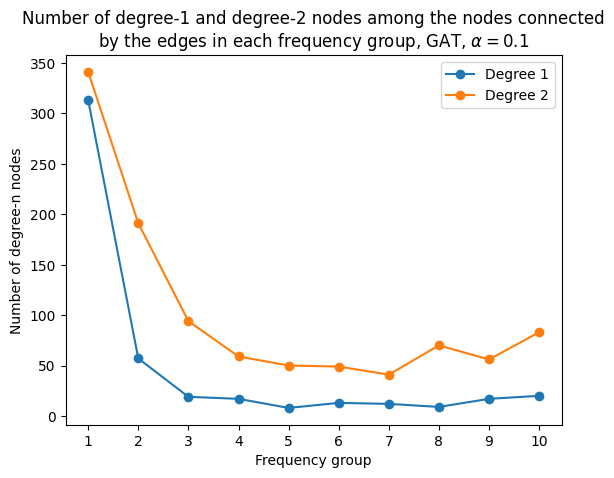

In [115]:
x = range(1, 11)

plt.figure()  # You can adjust the size of the figure
plt.plot(x, degree_one_nodes_per_bin_gat, label='Degree 1', marker='o')  # Plot array1
plt.plot(x, degree_two_nodes_per_bin_gat, label='Degree 2', marker='o')  # Plot array1

# Adding titles and labels
plt.title('Number of degree-1 and degree-2 nodes among the nodes connected\nby the edges in each frequency group, GAT, $\\alpha=0.1$')
plt.xticks(x)
plt.xlabel('Frequency group')
plt.ylabel('Number of degree-n nodes')
plt.legend()  # This adds a legend using the labels specified in the plot commands

# Show the plot
plt.show()

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

def calculate_closeness_centrality(data):
    G = to_networkx(data, to_undirected=True)
    closeness = nx.closeness_centrality(G)
    return closeness


closeness_centralities = torch.tensor([i[1] for i in calculate_closeness_centrality(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(closeness_centralities[nodes_in_bin]).item())

0.1627894937992096
0.13430961966514587
0.1475469022989273
0.14637352526187897
0.14692670106887817
0.1463272124528885
0.14773330092430115
0.14967861771583557
0.14969778060913086
0.15322807431221008


In [ ]:
def calculate_betweenness_centrality(data):
    G = to_networkx(data, to_undirected=True)
    betweenness = nx.betweenness_centrality(G)
    return betweenness


betweenness_centralities = torch.tensor([i[1] for i in calculate_betweenness_centrality(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(betweenness_centralities[nodes_in_bin]).item())

0.004246211610734463
0.0032905584666877985
0.003078036243095994
0.002942989580333233
0.0028201518580317497
0.0028571796137839556
0.0029597135726362467
0.003347666235640645
0.003840755671262741
0.004714811686426401


In [ ]:
def calculate_eigenvec_centrality(data):
    G = to_networkx(data, to_undirected=True)
    centrality = nx.eigenvector_centrality(G)
    return centrality


eigenvec_centralities = torch.tensor([i[1] for i in calculate_eigenvec_centrality(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(eigenvec_centralities[nodes_in_bin]).item())

0.01164113637059927
0.007233402691781521
0.0073810541070997715
0.0062959766946733
0.006511461455374956
0.0064836726523935795
0.006440081633627415
0.006205822341144085
0.007436093408614397
0.008360161446034908


In [ ]:
def calculate_clustering_coeff(data):
    G = to_networkx(data, to_undirected=True)
    clustering = nx.clustering(G)
    return clustering


clustering_coeffs = torch.tensor([i[1] for i in calculate_clustering_coeff(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(clustering_coeffs[nodes_in_bin]).item())

0.20944969356060028
0.18034528195858002
0.20606251060962677
0.23692448437213898
0.2647078335285187
0.2761887311935425
0.2894721031188965
0.2740843892097473
0.2638223171234131
0.2693707048892975
